In [12]:
# import
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.cluster import KMeans
from L63_noisy import intL63_noisy, intL63_noisy_fix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa import stattools 
from scipy.stats import gaussian_kde
import joblib
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
# from sklearn.metrics import silhouette_score
from scipy.integrate import odeint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# from FKNN import FuzzyKNN, calculate_distances
from sklearn.metrics import silhouette_score
from scipy import io
from scipy.linalg import det
from selecandies import physi_constrain, selc_candifunc, indicate, find_index, find_index_flatten 
from collections import defaultdict
import os
from collections import Counter
from scipy.io import loadmat


# fix the random seed
np.random.seed(2022)

In [13]:
# set experiment parameters
dt = 0.03  # model integration time step, dtda should be divisible to dt
N = int(1e6)  # integration time steps
res = 1 # save data interval 
eps = 0.75 # noise level

100%|███████████████████████████████| 999999/999999 [00:06<00:00, 148344.76it/s]


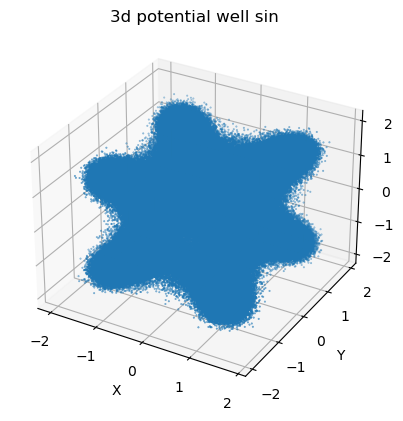

In [1]:
# modified 3d potential well (change one coefficient to time-dependent variable - sin)
import numpy as np
from scipy.integrate import odeint
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


def U(v, t):
    Ax = 1.05
    Ay = 1.1
    Az = 1.15
    x, y, z = v
    return (x - Ax)**2 * (x + Ax)**2 + (y - Ay)**2 * (y + Ay)**2 + (z - Az)**2 * (z + Az)**2

def force(v, t): 
    T = 3.84*2#  # period time
    Ax = 1.05 + 1.05*0.2*np.sin(t/T*math.pi*2)
    Ay = 1.1 + 1.1* 0.2* np.sin(t/T*math.pi*2)
    Az = 1.15 + 1.15* 0.2* np.sin(t/T*math.pi*2)

    x, y, z = v
    dxdt = -(2*(-Ax+x)**2*(Ax+x)+2*(-Ax+x)*(Ax+x)**2)
    dydt = -(2*(-Ay+y)**2*(Ay+y)+2*(-Ay+y)*(Ay+y)**2)
    dzdt = -(2*(-Az+z)**2*(Az+z)+2*(-Az+z)*(Az+z)**2)
    return np.array([dxdt,dydt,dzdt])

def potential_data(timesteps, dt, res, eps):
    x_f = np.zeros((3, timesteps))
    der = np.zeros((3, timesteps))
    
    for i in tqdm(range(1, timesteps)):
        dx = force(x_f[:, i-1], dt*(i-1)) * dt
        x_f[:, i] = x_f[:, i-1] + dx  + eps * np.sqrt(dt) * np.random.randn(3)
        der[:, i-1] = x_f[:, i] - x_f[:, i-1]
        
    dx = force(x_f[:, -1], dt*(timesteps-1)) * dt
    sol = x_f[:, -1] + dx  + eps * np.sqrt(dt) * np.random.randn(3)
    der[:, -1] = sol - x_f[:, -1]

    L2 = timesteps // res
    Dt = dt * res
    x = np.zeros((3, L2))
    
    for i in range(L2):
        x[:, i] = x_f[:, res*i]

    return x, Dt, der


x, dt, der = potential_data(N, dt, res, eps)

np.save('../../data/naturerun_PWell_sin.npy', x)
np.save('../../data/derivative_PWell_sin.npy', der)

# Set up the loop and plot
fig =  plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:], s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well sin')
plt.savefig('../../fig/3dPotentialWell_sin.png')
plt.show()

In [18]:
# load data
truth = np.load('../../data/naturerun_PWell_sin.npy')
truth.shape

(3, 1000000)

In [15]:
# save data to hdf5 file
save_res = 10
with h5py.File("../../data/potential_well_sin.hdf5", "w") as hfile:
    # Store data in the file
    hfile["x"] = truth[:,::save_res].T
    hfile["dt"] = dt*save_res


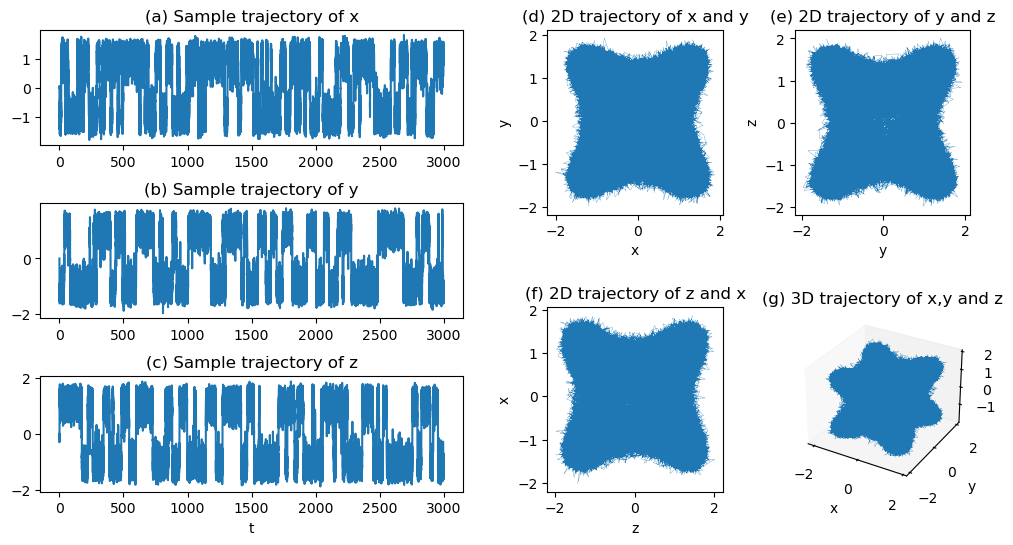

In [16]:
# Plot - sin
x1, y1, z1 = truth

sel0 = 0; sel1 = 100000 # plot time range
interv = 1 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)     # Adjust the overall spacing of the figure
gs0 = GridSpec(1, 2, figure=fig)

gs00 = gs0[0].subgridspec(3, 6)
ax1 = fig.add_subplot(gs00[0, :])
ax2 = fig.add_subplot(gs00[1, :])
ax3 = fig.add_subplot(gs00[2, :])

ax1.plot(xaxis, x1[sel0:sel1:interv])
# ax1.set_xlim(50, 100)
ax1.set_title('(a) Sample trajectory of x')

ax2.plot(xaxis, y1[sel0:sel1:interv])
# ax2.set_xlim(50, 100)
ax2.set_title('(b) Sample trajectory of y')

ax3.plot(xaxis, z1[sel0:sel1:interv])
# ax3.set_xlim(50, 100)
ax3.set_title('(c) Sample trajectory of z')
ax3.set_xlabel('t')

# create a new GridSpec for the second column
gs01 = gs0[1].subgridspec(2, 7)

ax4 = fig.add_subplot(gs01[0, :3])
ax5 = fig.add_subplot(gs01[0, 4:])
ax6 = fig.add_subplot(gs01[1, :3])
ax7 = fig.add_subplot(gs01[1, 4:], projection='3d')

ax4.plot(x1, y1, lw=0.2)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('(d) 2D trajectory of x and y')

ax5.plot(y1, z1, lw=0.2)
ax5.set_xlabel('y')
ax5.set_ylabel('z')
ax5.set_title('(e) 2D trajectory of y and z')

ax6.plot(z1, x1, lw=0.2)
ax6.set_xlabel('z')
ax6.set_ylabel('x')
ax6.set_title('(f) 2D trajectory of z and x')

ax7.plot(x1, y1, z1, lw=0.2)
ax7.set_xlabel("x")
ax7.set_ylabel("y")
ax7.set_zlabel("z")
ax7.set_title('(g) 3D trajectory of x,y and z')
ax7.grid(False)

plt.savefig('../../fig/Truth_traj_PWell_sin.png', dpi=150)
plt.show()

# 1. Classification

## 1.1 autocorrelation

x Decorrelation Time: 10.14 time units
y Decorrelation Time: 13.59 time units
z Decorrelation Time: 20.16 time units


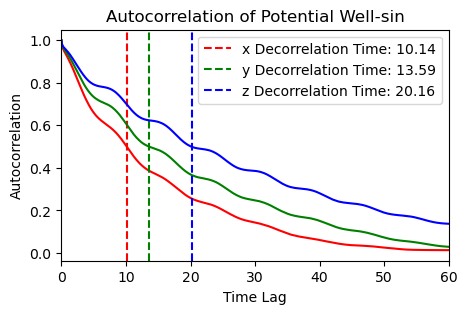

In [19]:
# compute autocorrelation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools 

nlags = 2000

autocorr_x = stattools.acf(truth[0,:],nlags=nlags)  # Autocorrelation of x component
autocorr_y = stattools.acf(truth[1,:],nlags=nlags)  # Autocorrelation of y component
autocorr_z = stattools.acf(truth[2,:],nlags=nlags)  # Autocorrelation of z component

# Find decorrelation time (time lag at which autocorrelation drops to a certain threshold)
threshold = 0.5
decorrelation_time_index = np.argmax(autocorr_x < threshold)
decorrelation_time_x = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_y < threshold)
decorrelation_time_y = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_z < threshold)
decorrelation_time_z = decorrelation_time_index * dt

tmax = dt*autocorr_x.shape[0]
t = np.arange(0.0, tmax, dt)
# Plot autocorrelation function and decorrelation time
plt.figure(figsize=(5,3))
plt.plot(t, autocorr_x, color='r')
plt.axvline(x=decorrelation_time_x, color='r', linestyle='--', label=f'x Decorrelation Time: {decorrelation_time_x:.2f}')
plt.plot(t, autocorr_y, color='g')
plt.axvline(x=decorrelation_time_y, color='g', linestyle='--', label=f'y Decorrelation Time: {decorrelation_time_y:.2f}')
plt.plot(t, autocorr_z, color='b')
plt.axvline(x=decorrelation_time_z, color='b', linestyle='--', label=f'z Decorrelation Time: {decorrelation_time_z:.2f}')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Potential Well-sin')
plt.legend()
plt.xlim(0, tmax)
# plt.show()
plt.savefig('../../fig/autocorr_PWell_sin.png', dpi=150)

print(f"x Decorrelation Time: {decorrelation_time_x:.2f} time units")
print(f"y Decorrelation Time: {decorrelation_time_y:.2f} time units")
print(f"z Decorrelation Time: {decorrelation_time_z:.2f} time units")



## 1.2 Clustering

### 1.2.1 K-means

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

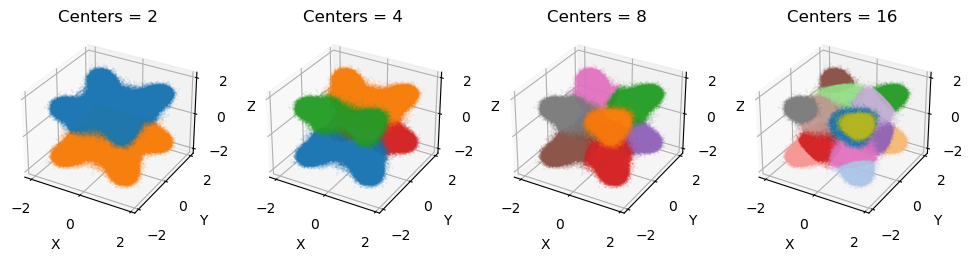

In [2]:
# Kmeans
%matplotlib inline
# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = X
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

ncenterss = [2,4,8,16]

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection='3d'))

for ncenters, ax in zip(ncenterss, axes1):
    kmeans = KMeans(n_clusters=ncenters)#, n_init='auto')
    kmeans.fit(data_matrix)
    labels = kmeans.labels_

    # save data
    dic = {'label':labels, 'centers':kmeans.cluster_centers_}
    np.save('../../data/Kmeans_{0:d}center_Pwell_sin.npy'.format(ncenters), dic)
    joblib.dump(kmeans, "../../data/kmeans_model_{0:d}center_PWell_sin.joblib".format(ncenters))

#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    for j in range(ncenters):
        ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    ax.set_title('Centers = {0}'.format(ncenters))

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Kmeans_PWell_sin.png',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


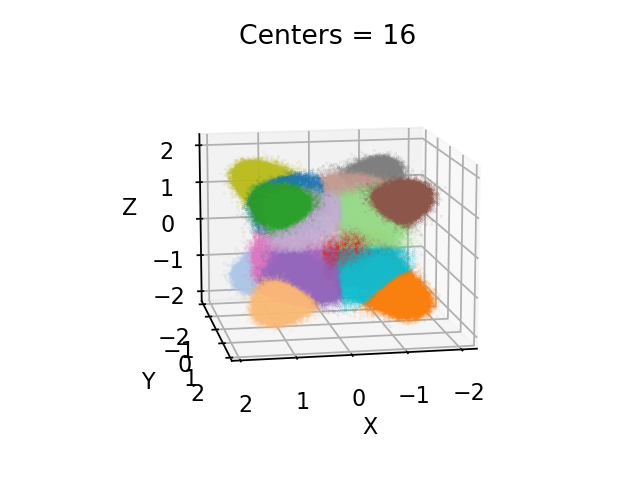

Text(0.5, 0.92, 'Centers = 16')

In [22]:
# check overlap for ncenters=16
%matplotlib notebook
fig1, axes1 = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
ncenters = 16
ax = axes1

# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = X
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']


dic = np.load('../../data/Kmeans_{0:d}center_Pwell_sin.npy'.format(16), allow_pickle=True)
labels = dic.item()['label']

# Plot assigned clusters, for each data point in training set
for j in range(ncenters):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('Centers = {0}'.format(ncenters))

### 1.2.2 Fuzzy Cmeans

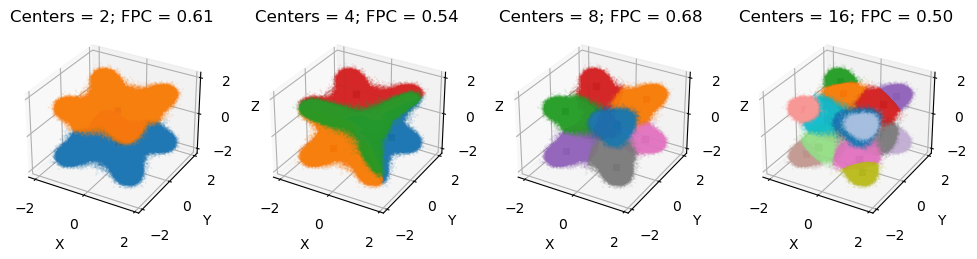

In [23]:
# Fuzzy C-Means
%matplotlib inline

def bi2fuzzy(nc, label):
    N = label.shape[0]
    membership = np.zeros((nc, N))
    for ic in range(nc):
        membership[ic, label==ic] = 1
        
    return membership

# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
ncenterss = [2,4,8,16]

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection='3d'))
fpcs = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

for ncenters, ax in zip(ncenterss, axes1):
    # initialize with kmeans
    dic = np.load('../../data/Kmeans_{0:d}center_Pwell_sin.npy'.format(ncenters), allow_pickle=True)
    lb = dic.item()['label']
    init_mem = bi2fuzzy(ncenters, lb)

    # # Perform Fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data_matrix.T, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership_bi = np.argmax(u, axis=0)
    cluster_membership = u

    for j in range(ncenters):
        ax.scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.scatter(pt[0], pt[1], pt[2], marker='s', s=20, color='black')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))

    # save data
    dic = {'label':cluster_membership_bi, 'membership':cluster_membership,'u0':u0,'d':d,'jm':jm,'p':p,'fpc':fpc}
    np.save('../../data/FuzKmeans_{0:d}center_PWell_sin.npy'.format(ncenters), dic)

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/FCmeans_PWell_sin.png')
plt.show()


<IPython.core.display.Javascript object>


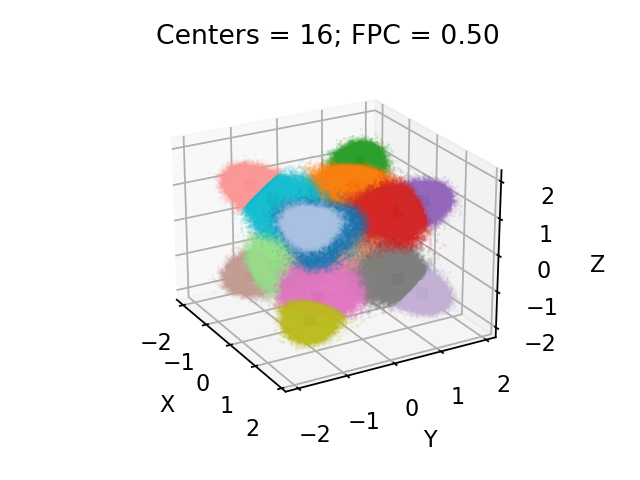

Text(0.5, 0.92, 'Centers = 16; FPC = 0.50')

In [24]:
# check overlap for ncenters=16
%matplotlib notebook

fig1, axes1 = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
fpcs = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

ncenters = 16
ax = axes1
for j in range(ncenters):
    ax.scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Mark the center of each fuzzy cluster
for pt in cntr:
    ax.scatter(pt[0], pt[1], pt[2], marker='s', s=20, color='black')

ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))


### 1.2.4 Ludo's Method

In [ ]:
# Ludo's method
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_sin_Ludo.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]

ncenterss = np.max(np.array(labels_)+1, axis=1)
ncenterss = ncenterss[:8]

print('number of clusters:', ncenterss)
print('time scales:', tscales)

# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = X
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

# Set up the loop and plot
nrow, ncol = (2,4)
fig1, axes1 = plt.subplots(nrow, ncol, figsize=(12, 8), subplot_kw=dict(projection='3d'))
ilabel = 0
for ncenters in ncenterss:
    labels = labels_[ilabel]
    
#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    iax = int(ilabel // ncol)
    jax = ilabel % ncol
    for j in range(ncenters):
        axes1[iax,jax].scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        axes1[iax,jax].set_xlabel('X')
        axes1[iax,jax].set_ylabel('Y')
        axes1[iax,jax].set_zlabel('Z')
#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    axes1[iax,jax].set_title('Centers = {0:d}, tscale={1:.2f}'.format(ncenters, tscales[ilabel]))

    ilabel += 1
    
plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Ludos_PWell_sin.png',dpi=150)
plt.show()

# 2. Surrogate Model

## 2.1 True signals

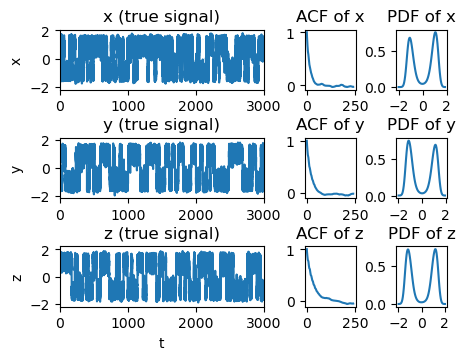

In [26]:
# Truth
%matplotlib inline

x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

Lag = 8000

fig = plt.figure(figsize=(5,3.6))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, (N) * dt, dt), x_truth)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, (N) * dt, dt), y_truth)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, (N) * dt, dt), z_truth)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x_truth, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y_truth, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z_truth, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth)
xx = np.linspace(np.min(x_truth), np.max(x_truth), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth)
xx = np.linspace(np.min(y_truth), np.max(y_truth), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth)
xx = np.linspace(np.min(z_truth), np.max(z_truth), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_PWell_sin.png', dpi=150)
plt.show()

(1000000,)


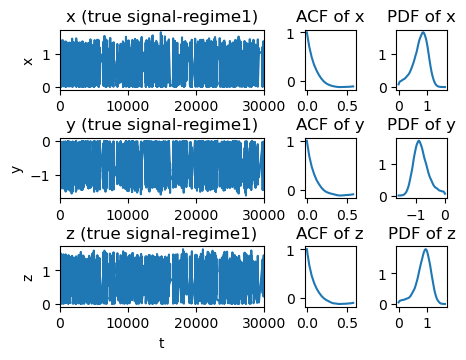

In [27]:
# truth regime1
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']
print(label.shape)

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Partition data into 2 regimes
bool_label = label == 0
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
indt1 = np.where(bool_label)[0]

# plot
fig = plt.figure(figsize=(5,3.6))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# # Remove last point from candidates
# indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm1_PWell_sin.png', dpi=150)
plt.show()

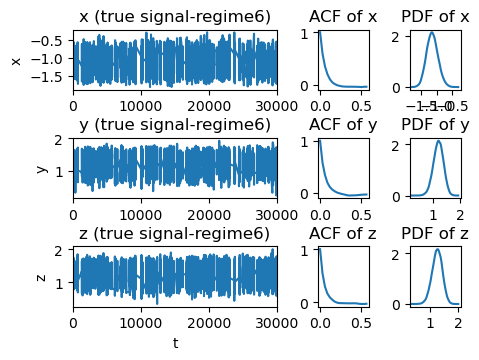

In [28]:
# truth regime6
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((const, x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Partition data into 2 regimes
bool_label = label == 5
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
All_Candidates1 = All_Candidates[:,bool_label]
indt1 = np.where(label==5)[0]

# plot
fig = plt.figure(figsize=(5,3.6))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime6)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime6)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime6)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
All_Candidates1 = All_Candidates1[:, :-1]
indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm6_PWell_sin.png', dpi=150)
plt.show()

## 2.2 Surrogate Model of the Complete System

In [18]:
# Model Identification
from scipy.linalg import det

# load label data
label = np.load('../../data/FuzKmeans_label_16center_PWell_sin.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Parameters
threshold = 0.0005 # threshold of causation entropy
L = All_Candidates.shape[0]

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_sin.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3')

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    All_Variables1 = np.vstack((All_Candidates, deriv[k,:]))
    All_Cov = np.cov(All_Variables1)

    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

CEM_Original1 = CEM
CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

print('Regime{:d}'.format(0))
print('Model structure (identified model):')
print(CEM_indicator1)
print('CEM_Original',CEM_Original1)

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3
Regime0
Model structure (identified model):
[[1 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]]
CEM_Original [[2.90168400e-02 2.79987740e-07 8.24447903e-06 7.96962250e-07
  7.02392724e-07 7.40215543e-07 1.45088793e-07 3.54618508e-06
  3.91717931e-07 3.97310729e-02 1.23017581e-06 1.02923022e-05]
 [2.25413643e-09 3.14031765e-02 5.78572166e-06 3.17302439e-07
  2.49986532e-07 1.80435568e-06 8.28643793e-07 7.31425729e-08
  5.68322973e-07 4.64429872e-09 4.18306633e-02 6.07666129e-06]
 [2.16005740e-06 4.71758618e-06 3.38537945e-02 1.40302988e-06
  3.38961970e-09 5.38147626e-07 4.84621177e-06 2.23807391e-05
  6.97069630e-06 2.81514919e-06 5.86828465e-06 4.40398237e-02]]


Candidate functions:
x, y, z, x^3, y^3, z^3
Model structure (truth):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
Model structure (Physics constrained surrogate model):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
Theta1_Constraint
 [ 3.07207303 -2.6141466   3.14641393 -2.43750229  3.22564602 -2.28852932]
sigma1
 [[ 0.80380777 -0.         -0.        ]
 [-0.          0.81093787 -0.        ]
 [-0.         -0.          0.81884731]]


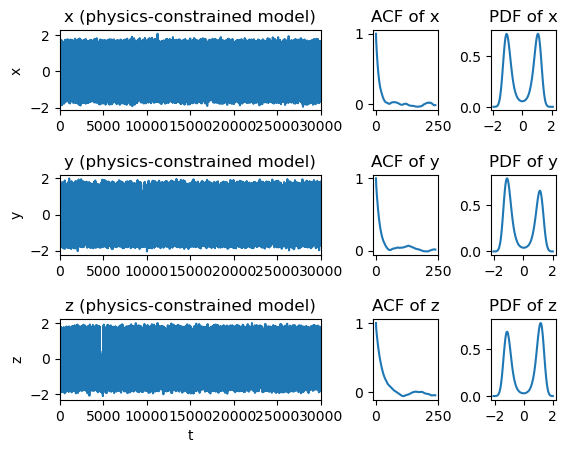

In [19]:
# Surrogate Model of the Complete System
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**3, y_truth**3, z_truth**3))

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)
print('Candidate functions:')
print('x, y, z, x^3, y^3, z^3')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 4] = 1
g = np.zeros((num_constraints,1))

Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))
All_Candidates1 = All_Candidates
x_truth1 = x_truth
y_truth1 = y_truth
z_truth1 = z_truth

for _ in range(10):
    count = 0
    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
        count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    Theta1_Constraint = Theta1[:,0]

Sigma1 = Sigma
print('Theta1_Constraint\n',Theta1_Constraint)
print('sigma1\n',(Sigma1/dt)**0.5)


N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

for i in range(1, N):
    der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * x1[i - 1]**3) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta1_Constraint[2] * y1[i - 1] + Theta1_Constraint[3] * y1[i - 1]**3) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta1_Constraint[4] * z1[i - 1] + Theta1_Constraint[5] * z1[i - 1]**3) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])


# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (physics-constrained model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (physics-constrained model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (physics-constrained model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag = 8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/CompletePerfectModel_PWell_sin.png', dpi=150)
plt.show()


## 2.3 Surrogate Model of the Regimes

In [30]:
# Model Identification - Kmeans
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_sin.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

Candidate functions:
dx:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0, type0
Model structure (identified physics-constrained model):
['x^3']
['y^3']
['z^3']
CEM_Original [[3.92783895e-05 3.46681512e-05 9.54730124e-05 1.02329771e-04
  4.88330395e-06 2.55506536e-04 3.19504328e-05 7.77816542e-05
  1.06579295e-02]
 [1.15723423e-04 1.88678386e-05 1.50801177e-04 1.92063883e-04
  3.28756651e-04 3.70209616e-05 5.07936289e-05 9.91137875e-05
  1.07669419e-02]
 [2.12224365e-04 2.07762557e-04 9.53371036e-05 3.84641634e-05
  2.52432277e-04 1.98669807e-04 1.91494257e-04 2.07353841e-04
  1.26561286e-02]]
Regime1, type0
Model structure (identified physics-constrained model):
['x^3']
['y', 'y^3']
['x', 'z', 'z^3']
CEM_Original [[6.91000018e-04 6.86502236e-04 8.63597491e-04 2.46212756e-05
  5.12837280e-04 9.92825035e-05 1.13748080e-04 1.26663520e-04
  1.03709082e-02]
 [7.51762955e-04 1.72751649e-03 1.07770321e-03 1.19739703e-04
  3

Candidate functions:
dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0
Model structure:
C_0+ ['x^3']
C_1+ ['y^3']
C_2+ ['z^3']
Theta1_Constraint
 [-2.6954911   1.54472709 -2.49377527 -1.69681936 -2.34106427  1.83959928]
sigma1
 [[ 0.76003709  0.         -0.        ]
 [ 0.          0.76368406  0.        ]
 [-0.          0.          0.76814083]]
Regime1
Model structure:
C_0+ ['x^3']
C_1+ ['y', 'y^3']
C_2+ ['x', 'z', 'z^3']
Theta1_Constraint
 [-2.48766851 -4.05318138  4.27857132 -3.34213225  1.09928085  1.07624299
  4.74317991 -3.25829187  0.25449101]
sigma1
 [[ 0.81106858  0.         -0.        ]
 [ 0.          0.81865124  0.        ]
 [-0.          0.          0.82622574]]
Regime2
Model structure:
C_0+ ['x^3']
C_1+ ['y', 'z', 'y^3']
C_2+ ['z', 'z^3']
Theta1_Constraint
 [-2.517266    4.13816088  3.62136138  1.27811222 -3.2386505   0.08078115
  4.18859937 -3.17589188  1.51854311]
sigma1
 [[ 0.80954668 -0.    

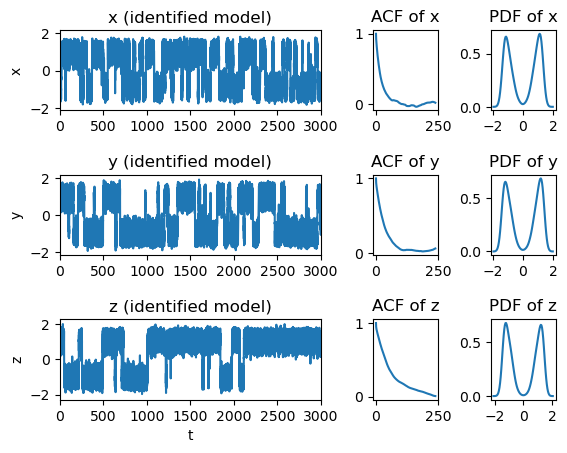

In [32]:
# surrogate model of regimes - Kmeans
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_sin.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    
    if rgm in (0,9,14):
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][4] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 1:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * y1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * x1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (2,5):
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * y1[i - 1] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 3:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 4:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 6:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (7,10,13):
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * y1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 8:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 11:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 12:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][4] * y1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 15:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * z1[i - 1]**2 + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()

    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr_PWell_sin.png', dpi=150)
plt.show()

In [ ]:
# the computational cost of regimes clasification may be more expensive than the integration

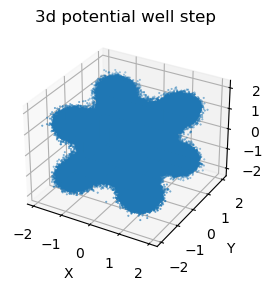

Counter({11.0: 81697, 1.0: 80750, 7.0: 76017, 8.0: 75278, 2.0: 71910, 10.0: 70272, 5.0: 68881, 13.0: 64144, 4.0: 57333, 0.0: 53116, 6.0: 52667, 9.0: 52659, 15.0: 52564, 14.0: 48319, 3.0: 47523, 12.0: 46870})


In [33]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.show()
print(Counter(pred_label))

In [ ]:
# new test for including more features - kmeans

In [34]:
# Model Identification - Kmeans - 12 candies
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [12, 12] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_sin.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

Candidate functions:
dx:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0, type0
Model structure (identified physics-constrained model):
['zx', 'x^3']
['yz', 'y^3']
['x', 'y', 'x^2', 'y^2', 'z^3']
CEM_Original [[3.92783895e-05 3.46681512e-05 9.54730124e-05 1.02329771e-04
  4.88330395e-06 2.55506536e-04 3.19504328e-05 7.77816542e-05
  1.06579295e-02]
 [1.15723423e-04 1.88678386e-05 1.50801177e-04 1.92063883e-04
  3.28756651e-04 3.70209616e-05 5.07936289e-05 9.91137875e-05
  1.07669419e-02]
 [2.12224365e-04 2.07762557e-04 9.53371036e-05 3.84641634e-05
  2.52432277e-04 1.98669807e-04 1.91494257e-04 2.07353841e-04
  1.26561286e-02]]
Regime1, type0
Model structure (identified physics-constrained model):
['x', 'y', 'z', 'x^3']
['x', 'y', 'z', 'y^3']
['x', 'y', 'z', 'z^3']
CEM_Original [[6.91000018e-04 6.86502236e-04 8.63597491e-04 2.46212756e-05
  5.12837280e-04 9.92825035e-05 1.13748080e-04 1.26663520e-04
  1.03709082e-02]

Candidate functions:
dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0
Model structure:
C_0+ ['zx', 'x^3']
C_1+ ['yz', 'y^3']
C_2+ ['x', 'y', 'x^2', 'y^2', 'z^3']
Theta1_Constraint
 [-0.23369827 -2.60549545  1.6416995  -0.08768106 -2.4625737  -1.73568271
 -0.94169584  0.48159906  0.23369827  0.08768106 -2.39294677  2.76545863]
sigma1
 [[ 0.76003709  0.         -0.        ]
 [ 0.          0.76368406  0.        ]
 [-0.          0.          0.76814083]]
Regime1
Model structure:
C_0+ ['x', 'y', 'z', 'x^3']
C_1+ ['x', 'y', 'z', 'y^3']
C_2+ ['x', 'y', 'z', 'z^3']
Theta1_Constraint
 [ 2.50312277 -0.67144145  1.0107349  -3.11995468 -0.12257272 -0.73471188
  4.7795145  -1.41441592 -3.4882254  -1.86107416  1.04960652 -1.14905348
  4.96909311 -3.32457565  1.75484997]
sigma1
 [[ 0.81106858  0.         -0.        ]
 [ 0.          0.81865124  0.        ]
 [-0.          0.          0.82622574]]
Regime2
Model structure:
C

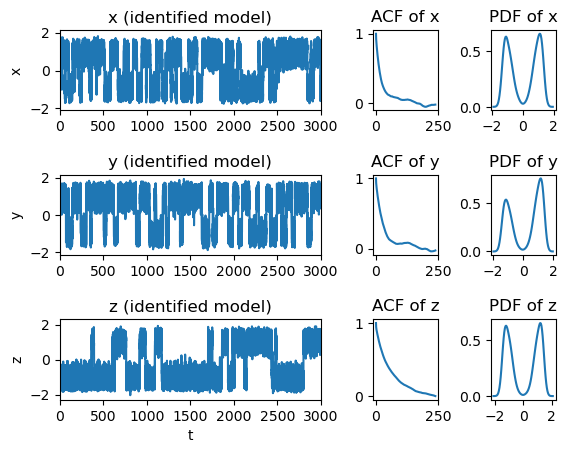

In [35]:
# surrogate model of regimes - kmeans - 12 candies
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_sin.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    
    if rgm == 0:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][11] + Theta_Constraints0[rgm][6] * x1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1] + Theta_Constraints0[rgm][8] * x1[i - 1]**2 + Theta_Constraints0[rgm][9] * y1[i - 1]**2 + Theta_Constraints0[rgm][10] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (1,5,7,8,10,11,13):
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][5] * x1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][14] + Theta_Constraints0[rgm][10] * x1[i - 1] + Theta_Constraints0[rgm][11] * y1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1] + Theta_Constraints0[rgm][13] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()  
    elif rgm == 2:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1] + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][4] * x1[i - 1] + Theta_Constraints0[rgm][5] * y1[i - 1] +  Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][9] * x1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 3:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][3] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][4] * z1[i - 1]**2 + Theta_Constraints0[rgm][5] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][7] * x1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1] + Theta_Constraints0[rgm][9] * y1[i-1]*z1[i-1] + Theta_Constraints0[rgm][10] * y1[i-1]**2 + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 4:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][2] * x1[i - 1] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1]**2 + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][8] * y1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1]**2 + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn() 
    elif rgm == 6:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1]**2 + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][4] * y1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1]**2 + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][8] * y1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][10] * x1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 9:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * y1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]**2 + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][4] * z1[i - 1] + Theta_Constraints0[rgm][5] * x1[i - 1]*y1[i - 1] + Theta_Constraints0[rgm][6] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**2 + Theta_Constraints0[rgm][8] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][10] * y1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][11] * y1[i - 1]**2 + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 12:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i-1]**2 + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][11] + Theta_Constraints0[rgm][6] * x1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1] + Theta_Constraints0[rgm][8] * z1[i-1]*x1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1]**2 + Theta_Constraints0[rgm][10] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()        
    elif rgm == 14:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i-1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][3] * y1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][4] * z1[i - 1]**2 + Theta_Constraints0[rgm][5] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][11] + Theta_Constraints0[rgm][7] * z1[i - 1] + Theta_Constraints0[rgm][8] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1]**2 + Theta_Constraints0[rgm][10] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()        
    elif rgm == 15:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1]**2 + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][4] * y1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1]**2 + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][9] * y1[i - 1]*z1[i-1] + Theta_Constraints0[rgm][10] * x1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()

    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr_PWell_sin_12candi.png', dpi=150)
plt.show()

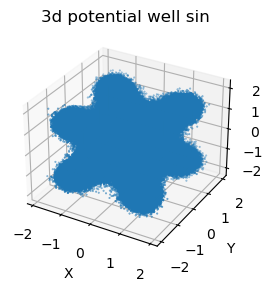

Counter({11.0: 86849, 5.0: 85991, 4.0: 78839, 2.0: 73974, 12.0: 72969, 1.0: 71233, 7.0: 59104, 8.0: 58973, 14.0: 57708, 10.0: 55621, 9.0: 55540, 6.0: 51904, 13.0: 50103, 0.0: 48885, 15.0: 47076, 3.0: 45231})


In [37]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well sin')
plt.show()
print(Counter(pred_label))

In [ ]:
# ***************************************************************************************************************

In [38]:
# Model Identification - FCM
# load label data
label = np.load('../../data/FuzKmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']
membership = np.load('../../data/FuzKmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['membership']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_sin.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

Candidate functions:
dx:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0, type0
Model structure (identified physics-constrained model):
['x^3']
['y^3']
['z^3']
CEM_Original [[1.85419538e-05 7.59501150e-05 1.84376575e-04 1.55961319e-04
  2.50150513e-05 3.29593440e-04 4.56459808e-05 1.35310296e-04
  1.15370113e-02]
 [1.88733295e-04 6.59942286e-06 2.00168814e-04 2.61974336e-04
  3.95307467e-04 4.82342031e-05 9.40555051e-05 1.16475591e-04
  1.15692083e-02]
 [2.91399978e-04 3.17139790e-04 2.53870914e-05 6.14429537e-05
  3.77462182e-04 3.04389112e-04 1.98822894e-04 2.62177394e-04
  1.26212265e-02]]
Regime1, type0
Model structure (identified physics-constrained model):
['x^3']
['y^3']
['y', 'z^3']
CEM_Original [[7.62490151e-05 1.27464853e-04 1.41123834e-04 1.65221950e-04
  5.17734495e-05 1.16710990e-04 9.05147976e-05 1.90560140e-04
  1.08453422e-02]
 [1.68055758e-04 4.37112735e-05 1.59621781e-04 2.86088639e-04
  2.21469532e

Candidate functions:
dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0
Model structure:
C_0+ ['x^3']
C_1+ ['y^3']
C_2+ ['z^3']
Theta1_Constraint
 [-2.64227521  1.61681638 -2.45123095 -1.7731553  -2.29311119  1.92073503]
sigma1
 [[ 0.76401315  0.         -0.        ]
 [ 0.          0.7685255   0.        ]
 [-0.          0.          0.77273332]]
Regime1
Model structure:
C_0+ ['x^3']
C_1+ ['y^3']
C_2+ ['y', 'z^3']
Theta1_Constraint
 [-2.55559176 -1.52434744 -2.47304798  1.76170843 -0.2366797  -2.3055909
  2.17800338]
sigma1
 [[ 0.75831439  0.          0.        ]
 [ 0.          0.76832765 -0.        ]
 [ 0.         -0.          0.77407287]]
Regime2
Model structure:
C_0+ ['x^3']
C_1+ ['z', 'y^3']
C_2+ ['y', 'z', 'z^3']
Theta1_Constraint
 [-2.60105579 -4.43854791  0.84529205 -2.51933707  3.83757933  1.02580824
  5.30741978 -3.47619917 -0.37112186]
sigma1
 [[ 0.81180251  0.          0.        ]
 [ 0.          0.

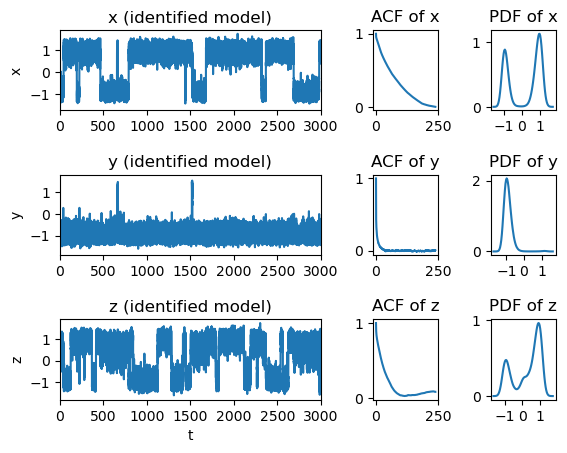

In [40]:
# surrogate model of regimes - FCM
def bi2fuzzy(nc, label):
    N = label.shape[0]
    membership = np.zeros((nc, N))
    for ic in range(nc):
        membership[ic, label==ic] = 1
        
    return membership
    
def surro_model(Theta_Constraints0,Sigmas0,dt,rgm,x1,y1,z1):
    if rgm in (0,3,11):
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][4] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (1,12):
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][4] * y1 + Theta_Constraints0[rgm][5] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (2,8,10):
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1 + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 4:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * y1 + Theta_Constraints0[rgm][3] * z1 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 5:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * y1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * x1 + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 6:
        der_x = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1 + Theta_Constraints0[rgm][1] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 7:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 9:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * z1**2 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * y1*z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn() 
    elif rgm in (13,15):
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * y1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1 + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 14:
        der_x = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1 + Theta_Constraints0[rgm][1] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
        
    return der_x, der_y, der_z
    
# load label data
label = np.load('../../data/FuzKmeans_16center_Pwell_sin.npy',allow_pickle=True).item()['label']

# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

# prepare the FCM model
# initialize with kmeans
dic = np.load('../../data/Kmeans_{0:d}center_Pwell_sin.npy'.format(ncenters), allow_pickle=True)
lb = dic.item()['label']
init_mem = bi2fuzzy(ncenters, lb)

# Perform Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_matrix.T, ncenters, 2, error=0.005, maxiter=300, init=init_mem)

pred_label = np.zeros(N)

for i in range(1, N):
#     rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    newdata = np.array([x1[i-1],y1[i-1],z1[i-1]])[:,None]
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(newdata, cntr, 2, error=0.005, maxiter=300)
    u = np.squeeze(u)
    
    # find the first k_model for combination
    k_model = 3
    largest_rgm = np.argsort(u)[-k_model:][::-1]
    largest_mem = u[largest_rgm] / np.sum(u[largest_rgm])
    pred_label[i-1]  =largest_rgm[0]

    dx,dy,dz = (0,0,0)
    for j in range(k_model):
        dx_tmp, dy_tmp, dz_tmp = surro_model(Theta_Constraints0,Sigmas0,dt,largest_rgm[j],x1[i-1],y1[i-1],z1[i-1])
        dx += dx_tmp * largest_mem[j]
        dy += dy_tmp * largest_mem[j]
        dz += dz_tmp * largest_mem[j]
        
    der_x[i-1] = dx
    der_y[i-1] = dy
    der_z[i-1] = dz
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = pred_label[N-2]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr_PWell_sin_FCM.png', dpi=150)
plt.show()

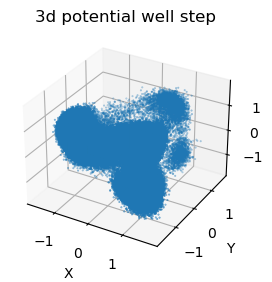

Counter({15.0: 340418,
         0.0: 266796,
         6.0: 233025,
         8.0: 57790,
         3.0: 39433,
         10.0: 36297,
         7.0: 19589,
         14.0: 3361,
         4.0: 1479,
         12.0: 877,
         2.0: 495,
         9.0: 304,
         11.0: 136})

In [41]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.show()

Counter(pred_label)

In [42]:
largest_mem

array([0.44074594, 0.32922047, 0.23003359])

In [ ]:
# ***************************************************************************************************************

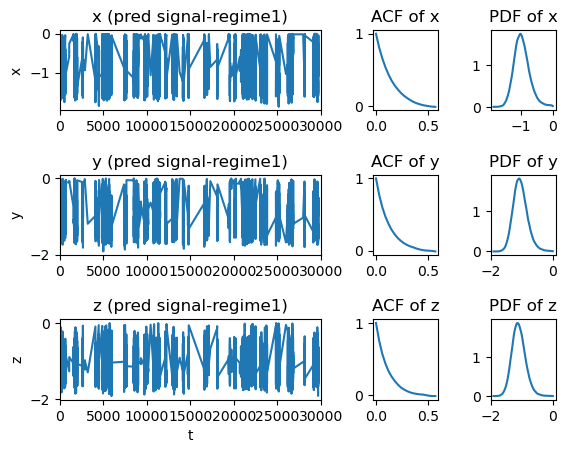

In [74]:
# plot regime1 CEM
boolpredlab = pred_label==0
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
indt1 = np.where(boolpredlab)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm1_CEM_PWell.png', dpi=150)
plt.show()

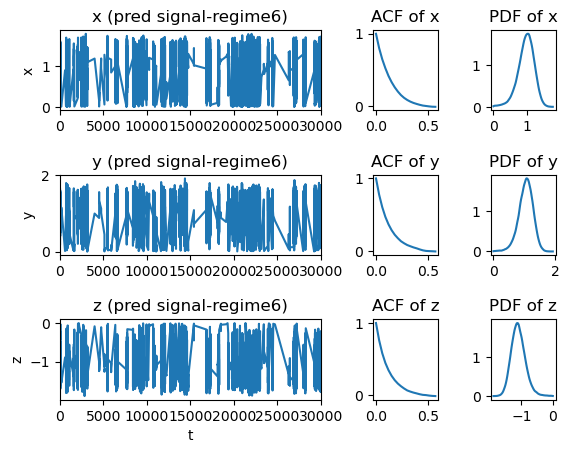

In [75]:
# plot regime6 CEM
boolpredlab = pred_label==5
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
indt1 = np.where(boolpredlab)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime6)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime6)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime6)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm6_CEM_PWell.png', dpi=150)
plt.show()

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:11: RuntimeWarning: overflow encountered in scalar power
  der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:12: RuntimeWarning: overflow encountered in scalar power
  der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:13: RuntimeWarning: overflow encountered in scalar power
  der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:470: R

ValueError: array must not contain infs or NaNs

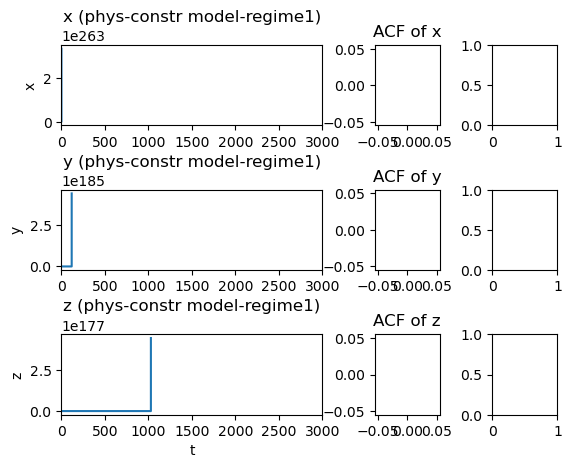

In [69]:
# independent run regime1 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

rgm = 0
for i in range(1, N):
    der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (phys-constr model-regime1)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (phys-constr model-regime1)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (phys-constr model-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/Regime1CEM_PWell.png', dpi=150)
plt.show()

Candidate functions:
x, y, z, x^2, y^2, z^2
Model structure (Physics constrained surrogate model):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
regime:  0
Theta1_Constraint
 [ 7.49705219e+00  7.18657403e+00 -2.73656176e-01 -6.19774128e-16
 -2.53359890e-01  1.80274712e-16]
sigma1
 [[ 0.79177317  0.          0.        ]
 [ 0.          0.79608101 -0.        ]
 [ 0.         -0.          0.80245872]]
regime:  1
Theta1_Constraint
 [ 7.47742621e+00 -7.16180913e+00 -2.77518287e-01 -6.40152810e-17
 -2.53913736e-01  1.07282864e-15]
sigma1
 [[ 0.7927713   0.          0.        ]
 [ 0.          0.79633003 -0.        ]
 [ 0.         -0.          0.80336441]]
regime:  2
Theta1_Constraint
 [ 7.52275189e+00  7.19652769e+00 -2.76049361e-01 -7.97081989e-16
 -2.55844067e-01 -7.16318147e-16]
sigma1
 [[ 0.79002453 -0.          0.        ]
 [-0.          0.79432007 -0.        ]
 [ 0.         -0.          0.80578819]]
regime:  3
Theta1_Constraint
 [ 7.59619419e+00  7.26141585e+00 -2.76066025e-01 -3.82923638

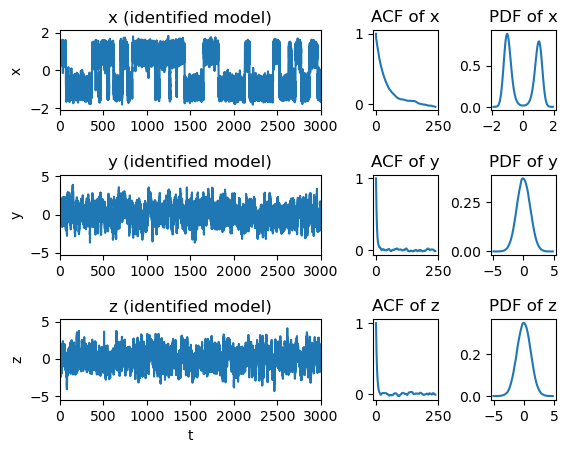

In [101]:
# CG surrogate model of regimes
# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2))

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label][:, :-1])   # Remove last point from candidates
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)

print('Candidate functions:')
print('x, y, z, x^2, y^2, z^2')
# print('Model structure (truth):')
# print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 3] = 1
H[1, 5] = 1
g = np.zeros((num_constraints,1))
Theta_Constraints = []
Sigmas = []

for nc in range(ncenters):
    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))

                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                
                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
        Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
#         Theta1_Constraint = Theta1
    
    Sigmas.append(Sigma)
    Theta_Constraints.append(np.squeeze(Theta1_Constraint))

    Sigma1 = Sigma
    print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
#     print('Sigma1\n',Sigma1)
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("kmeans_model_PWell.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCGCEM_PWell.png', dpi=150)
plt.show()